In [1]:
import numpy as np
import scipy as sp
from scipy import signal
import sklearn as sk
from sklearn import neighbors
import preprocessing as pp
import utilities as u
from matplotlib import pyplot as plt
import pickle
import os
from scipy.interpolate import interp1d as spline
from sklearn.linear_model import HuberRegressor as hreg

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
def gaussian(mu,sigma,x):
    '''radial basis function centered at 'mu' with width 'sigma', sampled at 'x' '''
    return np.exp(-(mu-x)**2/sigma**2)

getf = lambda s : s*2.5 + (1-s)*3.5
gettheta = lambda s: (s*60. + (1-s)*10.)*np.pi/180
xfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)-np.sin(gettheta(s)+np.pi/4.))) 
yfreq = lambda s: np.abs(getf(s)*1500/120*(np.cos(gettheta(s) + np.pi/4.)+np.sin(gettheta(s)+np.pi/4.))) 
ang = lambda x,y: np.arctan(x/y)*180/np.pi

wallmorphx = lambda s: 1.2*(xfreq(s)-xfreq(-.1))/(xfreq(1.1)-xfreq(-.1))-.1
wallmorphy = lambda s: 1.2*(yfreq(s)-yfreq(-.1))/(yfreq(1.1)-yfreq(-.1))-.1

In [3]:
df = pp.load_session_db(dir='D:\\')
# df = pp.load_session_db()
df = df[df['RewardCount']>40]
df = df[df['Imaging']==1]
df = df.sort_values(['MouseName','DateTime','SessionNumber'])
df = df[df["Track"]=="TwoTower_foraging"]

In [4]:
# load sf regression info for priors
with open("D:\\Morph_Results\\rare_sf_regression.pkl",'rb') as f:
    rare_sfreg = pickle.load(f)
    
with open("D:\\Morph_Results\\freq_sf_regression.pkl",'rb') as f:
    freq_sfreg = pickle.load(f)

In [5]:
def mean_prior_post(dict_sfreg,sigma_likelihood=.3,x=np.linspace(-.1,1.1,num=1000)[np.newaxis,:]):
    mice = [mouse for mouse in dict_sfreg.keys()]
    priors = np.zeros([len(mice),x.shape[1]])
    for i, (mouse,res) in enumerate(dict_sfreg.items()):
        _prior=None
        for _p in res['priors']:
            if _prior is None:
                _prior = _p
            else:
                _prior+=_p
        _prior = _prior/_prior.sum()
        priors[i,:]=_prior
        
    prior = _prior.mean(axis=0,keepdims=True)
    prior = prior/prior.sum()
    post = prior*gaussian(np.linspace(-.11,1.11,num=1000)[:,np.newaxis],sigma_likelihood,np.linspace(-.3,1.3,num=1000)[np.newaxis,:])
    post = post/post.sum(axis=1)
    return priors, prior, post
rare_priors,rare_prior,rare_post = mean_prior_post(rare_sfreg)
freq_priors,freq_prior,freq_post = mean_prior_post(freq_sfreg)

In [240]:
def calculate_posterior(prior,morphs,xx_lims = (-.1,1.1)):
    xx = np.linspace(xx_lims[0],xx_lims[1],num=prior.size)
    post = prior*gaussian(wallmorphx(morphs[:,np.newaxis]),.3,xx[np.newaxis,:])
    post = post/post.sum(axis=1,keepdims=True)
    return post, xx

def make_sampling_spline(xx,prob):
    cum_prob = np.cumsum(prob)
    cum_prob[0],cum_prob[-1] = 0,1
    
    return spline(cum_prob,xx)

# sample from posterior
def simulate_trial(prior,morphs, n_neurons=100,n_samps=1,rbf_sigma=.4):
    post, xx = calculate_posterior(prior,morphs)
    neurons = np.zeros([morphs.shape[0],n_neurons*n_samps])
    _nn = np.linspace(-.1,1.1,num=n_neurons)
    for trial in range(post.shape[0]):
        samplingspline = make_sampling_spline(xx,post[trial,:])
#         cum_post_t = np.cumsum(post[trial,:])
#         cum_post_t[0],cum_post_t[-1] = 0,1
#         samplingspline  = spline(cum_post_t,xx)
        
        post_samples = samplingspline(np.random.rand(n_samps))
        for samp_i in range(post_samples.size): 
#             do = np.ones(_nn.shape)
#             do[np.random.permutation(_nn.size-1)[:250]]=0
            neurons[trial,n_neurons*samp_i:n_neurons*(samp_i+1)] = gaussian(_nn,rbf_sigma,post_samples[samp_i]) 
    
    simdata=np.random.gamma(neurons) + np.random.gamma(.5*np.random.rand(*neurons.shape))
    
    simdata_norm = simdata/np.linalg.norm(simdata,axis=1,ord=2,keepdims=True)

    simdata_sm = np.dot(simdata_norm,simdata_norm.T)
    trial_info = {}
    trial_info['morphs']=np.copy(morphs)
    trial_info['morphs'][morphs<.1]=0
    trial_info['morphs'][morphs>.9]=1
    sf = u.similarity_fraction(simdata,trial_info)
    
    return simdata, simdata_sm, sf

def simmat_distribution(morphs,n_neurons,prior,nperms=1000,rbf_sigma=.4,n_samps=1):
    SIMDATA, SIMDATA_SM, SF = [],[],[]
    for it in range(nperms):
        if it%100 == 0:
            print(it)
        simdata,simdata_sm,sf = simulate_trial(prior,morphs,n_samps=n_samps,n_neurons=n_neurons,rbf_sigma = rbf_sigma)
        SIMDATA.append(simdata)
        SIMDATA_SM.append(simdata_sm)
        SF.append(sf)
    return np.array(SIMDATA), np.array(SIMDATA_SM), np.array(SF)

def run_simmat_distributions(sess):
    with open(os.path.join("D:\\Suite2P_Data\\",sess["MouseName"],"%s_%s_%i.pkl" % (sess["Track"],sess["DateFolder"],sess["SessionNumber"])),'rb') as f:
        data = pickle.load(f)
    
    S, tstart_inds, teleport_inds,VRDat = np.copy(data["S"]), data["tstart_inds"], data["teleport_inds"],data["VRDat"]
    S[np.isnan(S)]=0
    S = S/1546 #np.percentile(S,95,axis=0,keepdims=True)
    S_trial_mat = u.make_pos_bin_trial_matrices(np.copy(S),data['VRDat']['pos']._values,tstart_inds,
                                                teleport_inds,bin_size=10,mat_only=True)
    
    trial_info = data['trial_info']
    morphs = trial_info['morphs']+trial_info['wallJitter']
    morphsort = np.argsort(morphs)
    morphs = morphs[morphsort]
    trial_info['morphs'] = trial_info['morphs'][morphsort]

    S_trial_mat = S_trial_mat[morphsort,:,:]
    S_trial_mat = sp.ndimage.filters.gaussian_filter1d(S_trial_mat,2,axis=1)
    S_trial_mat[np.isnan(S_trial_mat)]=0
    S_tmat = S_trial_mat.reshape(S_trial_mat.shape[0],-1)
    S_tmat_norm = S_tmat/(np.linalg.norm(S_tmat,axis=1,ord=2,keepdims=True)+1E-8)
    
    
    SIMDATA,SIMDATA_SM,SIMDATA_SF = {},{},{}
    for prior,name in zip([rare_prior,freq_prior],['rare','freq']):
        print(name)
        sd,sdsm,sdsf = simmat_distribution(morphs,S_trial_mat.shape[-1],prior,nperms=1000)
        SIMDATA[name],SIMDATA_SM[name], SIMDATA_SF[name]= sd, sdsm,sdsf
    return morphs,S_trial_mat, np.dot(S_tmat_norm,S_tmat_norm.T), u.similarity_fraction(S_trial_mat,trial_info), SIMDATA, SIMDATA_SM, SIMDATA_SF

# Figures for schematic of how model works

0.0
0.3
0.6
0.8999999999999999
1000


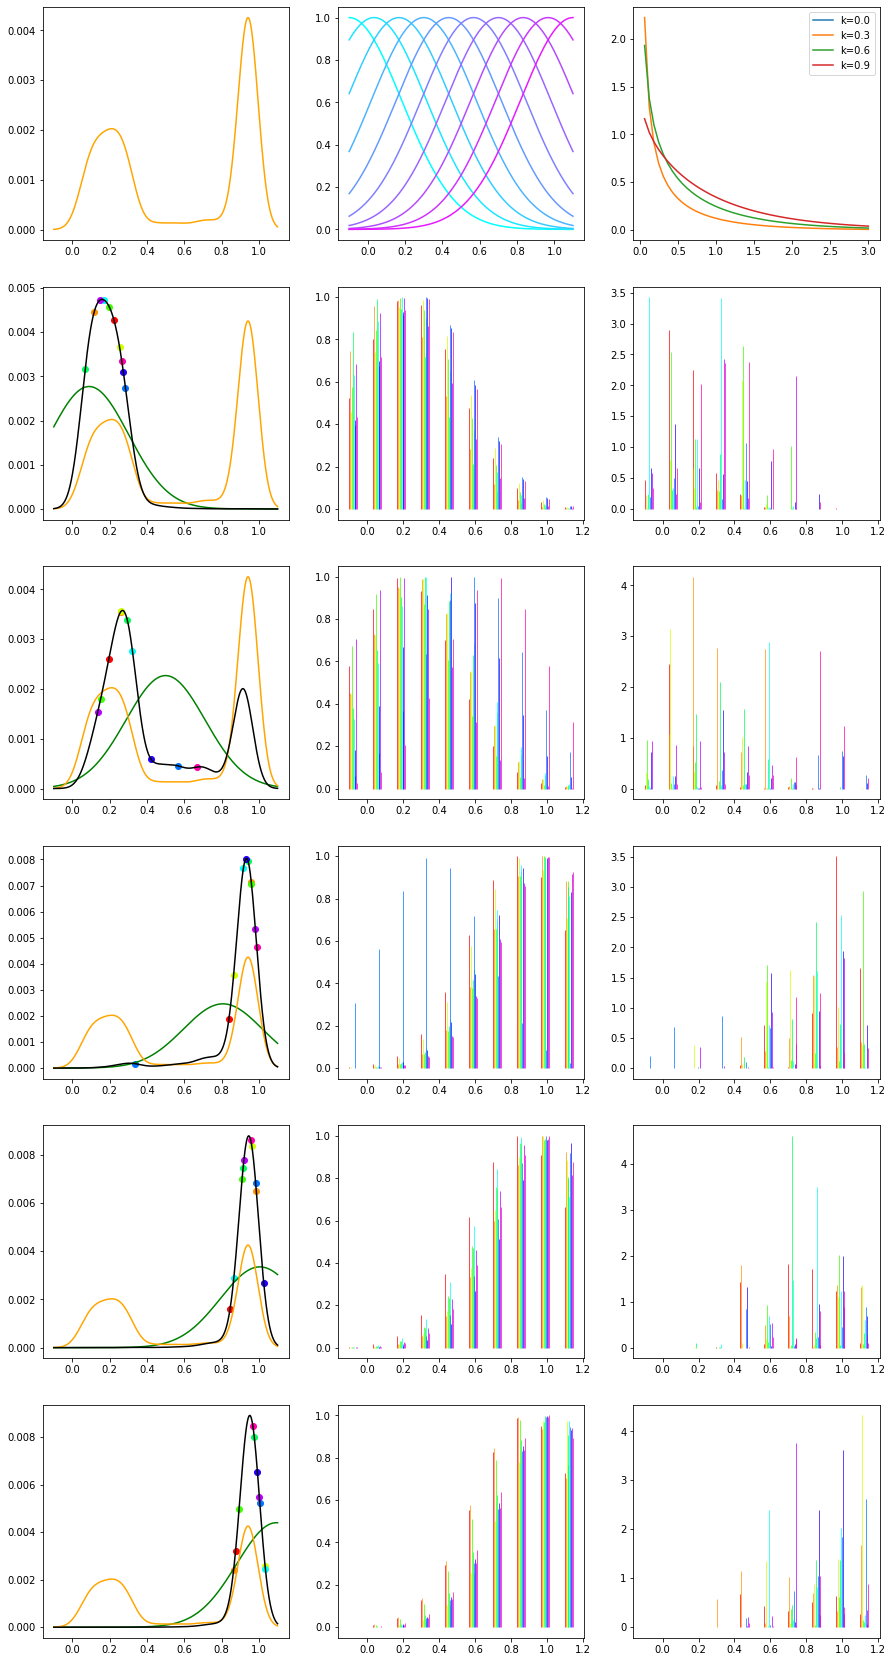

In [7]:
xx = np.linspace(-.1,1.1,num=rare_prior.size)
f,ax = plt.subplots(6,3,figsize=[15,30])


ax[0,0].plot(xx,rare_prior.ravel(),color='orange')
_x = np.linspace(0,3)
for alpha in np.arange(0,1,.3).tolist(): 
    print(alpha)
    ax[0,2].plot(_x,sp.stats.gamma.pdf(_x,alpha),label="k=%.1f" % alpha )
ax[0,2].legend()
    
# ax[0,1].plot(xx,freq_prior.ravel(),color='blue')
mus = np.linspace(-.1,1.1,num = 10)
for i, mu in enumerate(mus.tolist()):
    ax[0,1].plot(xx,gaussian(mu,.4,xx),color=plt.cm.cool(np.float(i)/10.))
shats= np.array([0, .25,.5,.75,1])
print(rare_prior.size)
post, xx = calculate_posterior(rare_prior,shats)
for j,shat in enumerate(shats.tolist()):
    l = gaussian(wallmorphx(shat),.3,xx)
    l = l/l.sum()
    ax[j+1,0].plot(xx,l,color='green')
    ax[j+1,0].plot(xx,rare_prior.ravel(),color='orange')
    
    ax[j+1,0].plot(xx,post[j,:],color='black')
    post_spline = spline(xx,post[j,:])
    
    
    # sample 3 times
    sampling_spline=make_sampling_spline(xx,post[j,:])
    eps = 5E-3
    for s in range(10):
        sample = sampling_spline(np.random.rand(1))
        ax[j+1,0].scatter(sample,post_spline(sample), c= np.array(plt.cm.hsv(s/10.))[np.newaxis,:])
        pop_tf = gaussian(mus,.4,sample)
#         print(pop_tf.shape)
        ax[j+1,1].vlines(mus+eps*s,0,pop_tf,color=plt.cm.hsv(s/10.),linewidths=.7)

        ax[j+1,2].vlines(mus+eps*s,0,np.random.gamma(pop_tf),color=plt.cm.hsv(s/10.),linewidth=.7)

    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\schematic_figs.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\schematic_figs.png",format='png')

# Confirming that this model reproduces the posterior and superficially has the statistics of the real neural data

In [8]:
# confirm that this gives back a representation of the posterior
linmorphs = np.linspace(-.1,1.1,num=100)
rare_post,xx = calculate_posterior(rare_prior,linmorphs,xx_lims = (-.1,1.1))
rare_simdat,rare_sm, rare_sf = simmat_distribution(linmorphs,1000,rare_prior,nperms=1000,rbf_sigma=.1)
rare_simdat_wide,rare_sm, rare_sf_wide = simmat_distribution(linmorphs,1000,rare_prior,nperms=1000,rbf_sigma=.4)

print(rare_simdat.shape)
map_estimate = xx[np.argmax(rare_post,axis=1)]
for p in range(100):
    linmodel = hreg().fit(rare_sf[p:p+1,:].T,map_estimate)
    rare_sf[p,:] = linmodel.predict(rare_sf[p:p+1,:].T)
    linmodel = hreg().fit(rare_sf_wide[p:p+1,:].T,map_estimate)
    rare_sf_wide[p,:] = linmodel.predict(rare_sf_wide[p:p+1,:].T)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900
(1000, 100, 1000)


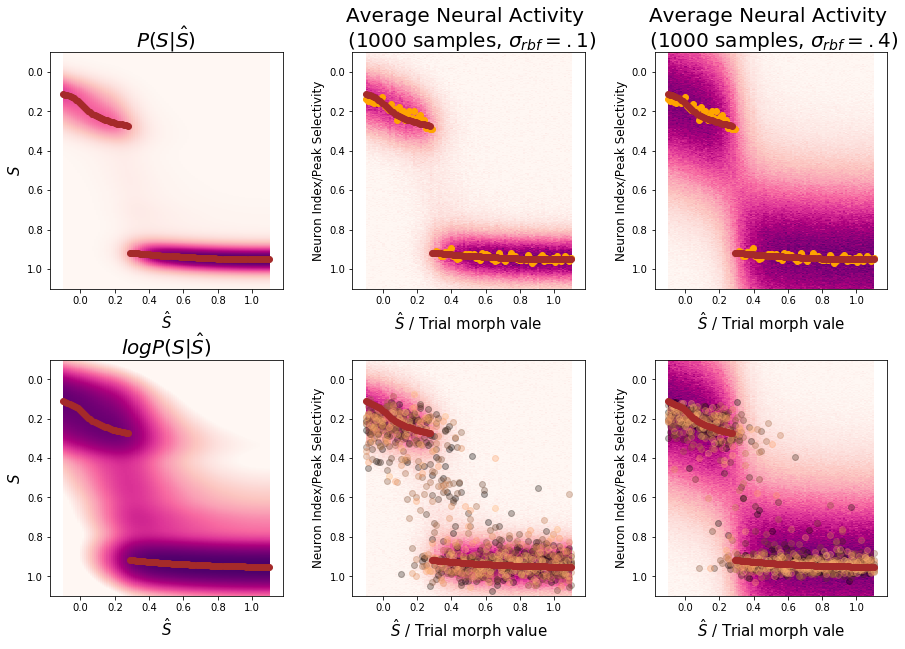

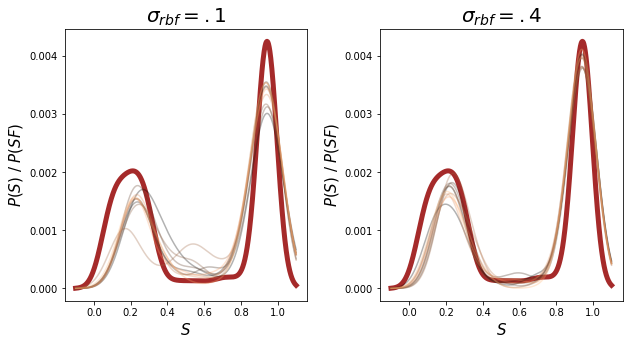

In [248]:
f,ax = plt.subplots(2,3,figsize=[15,10])
f.subplots_adjust(hspace=.3,wspace=.3)
ax[0,0].imshow(rare_post.T,cmap = 'RdPu',aspect='auto',vmin=np.percentile(rare_post,20),extent = [-.1,1.1,1.1,-.1])
ax[0,0].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown')
ax[0,0].set_ylabel("$ S $",fontsize=15)
ax[0,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[0,0].set_title("$P(S|\hat{S})$",fontsize=20)



ax[1,0].imshow(np.log(rare_post.T),cmap = 'RdPu',aspect='auto',vmin=np.percentile(np.log(rare_post),20),extent = [-.1,1.1,1.1,-.1])
ax[1,0].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown')
ax[1,0].set_ylabel("$ S $",fontsize=15)
ax[1,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[1,0].set_title("$log P(S|\hat{S})$",fontsize=20)

rare_simdat_mean = rare_simdat.mean(axis=0)
ax[0,1].imshow(rare_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1])
ax[0,1].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
ax[0,1].scatter(linmorphs,xx[np.argmax(rare_simdat_mean,axis=1)],color='orange')
ax[0,1].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,1].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,1].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.1$)",fontsize=20)

ax[1,1].imshow(rare_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1])
ax[1,1].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
ax[1,1].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,1].set_xlabel("$\hat{S}$ / Trial morph value",fontsize=15)
for j in range(0,100,10):
    ax[1,1].scatter(linmorphs,rare_sf[j,:],zorder=1,color=plt.cm.copper(np.float(j)/100.),alpha=.3)

rare_simdat_wide_mean = rare_simdat.mean(axis=0)
ax[0,2].imshow(rare_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1],zorder=0)
ax[0,2].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
ax[0,2].scatter(linmorphs,xx[np.argmax(rare_simdat_wide_mean,axis=1)],color='orange')
ax[0,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,2].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.4$)",fontsize=20)


ax[1,2].imshow(rare_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(rare_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1],zorder=0)
ax[1,2].scatter(linmorphs,xx[np.argmax(rare_post,axis=1)],color='brown',zorder=10)
ax[1,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
# ax[3].scatter(linmorphs,rare_sf_wide.mean(axis=0))
for j in range(0,100,10):
    ax[1,2].scatter(linmorphs,rare_sf_wide[j,:],zorder=1,color=plt.cm.copper(np.float(j)/100.),alpha=.3)
    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_confirmation.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_confirmation.png",format='png')

f,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(xx,rare_prior.ravel(),color='brown',linewidth=5)
ax[1].plot(xx,rare_prior.ravel(),color='brown',linewidth=5)
edges = np.linspace(-.1,1.1,num=20)
centers = (edges[:-1] + edges[1:])/2.
for j in range(0,100,10):
    _j_rare_sf_bins = np.mean(gaussian(rare_sf[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    ax[0].plot(xx,_j_rare_sf_bins/_j_rare_sf_bins.sum(),color = plt.cm.copper(np.float(j)/100.),alpha=.3)
    _j_rare_sf_wide_bins = np.mean(gaussian(rare_sf_wide[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    ax[1].plot(xx,_j_rare_sf_wide_bins/_j_rare_sf_wide_bins.sum(),color = plt.cm.copper(np.float(j)/100.),alpha=.3)
    
ax[0].set_xlabel("$S$",fontsize=15)
ax[1].set_xlabel("$S$",fontsize=15)

ax[0].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)
ax[1].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)


ax[0].set_title("$\sigma_{rbf}=.1$",fontsize = 20)
ax[1].set_title("$\sigma_{rbf}=.4$",fontsize = 20)

f.subplots_adjust(wspace=.3)
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_marginal_hist.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\rare_model_marginal_hist.png",format='png')

In [10]:
freq_post,xx = calculate_posterior(freq_prior,linmorphs,xx_lims = (-.1,1.1))
freq_simdat,freq_sm, freq_sf = simmat_distribution(linmorphs,1000,freq_prior,nperms=1000,rbf_sigma=.1)
freq_simdat_wide,freq_sm, freq_sf_wide = simmat_distribution(linmorphs,1000,freq_prior,nperms=1000,rbf_sigma=.4)


map_estimate = xx[np.argmax(freq_post,axis=1)]
for p in range(100):
    linmodel = hreg().fit(freq_sf[p:p+1,:].T,map_estimate)
    freq_sf[p,:] = linmodel.predict(freq_sf[p:p+1,:].T)
    linmodel = hreg().fit(freq_sf_wide[p:p+1,:].T,map_estimate)
    freq_sf_wide[p,:] = linmodel.predict(freq_sf_wide[p:p+1,:].T)

0
100
200
300
400
500
600
700
800
900
0
100
200
300
400
500
600
700
800
900


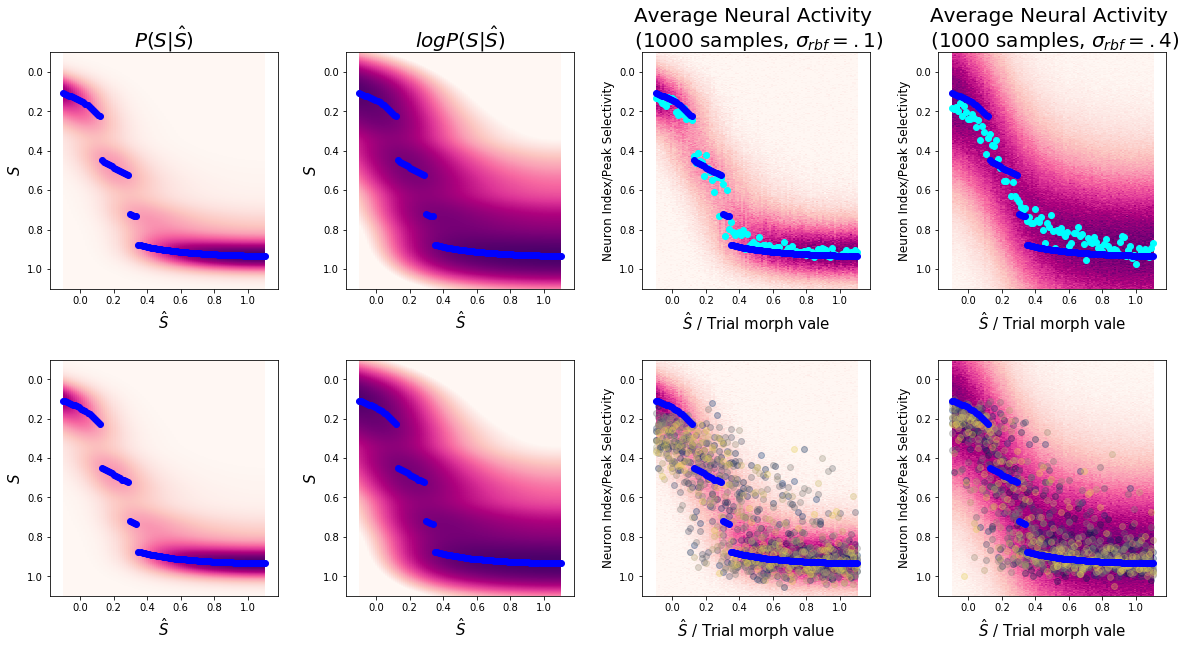

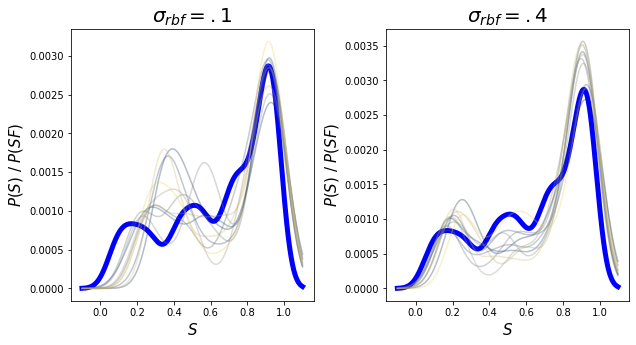

In [249]:
f,ax = plt.subplots(2,4,figsize=[20,10])
f.subplots_adjust(hspace=.3,wspace=.3)
ax[0,0].imshow(freq_post.T,cmap = 'RdPu',aspect='auto',vmin=np.percentile(freq_post,20),extent = [-.1,1.1,1.1,-.1])
ax[0,0].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue')
ax[0,0].set_ylabel("$ S $",fontsize=15)
ax[0,0].set_xlabel("$\hat{S}$",fontsize=15)
ax[0,0].set_title("$P(S|\hat{S})$",fontsize=20)

ax[1,0].imshow(freq_post.T,cmap = 'RdPu',aspect='auto',vmin=np.percentile(freq_post,20),extent = [-.1,1.1,1.1,-.1])
ax[1,0].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue')
ax[1,0].set_ylabel("$ S $",fontsize=15)
ax[1,0].set_xlabel("$\hat{S}$",fontsize=15)


ax[0,1].imshow(np.log(freq_post.T),cmap = 'RdPu',aspect='auto',vmin=np.percentile(np.log(freq_post),20),extent = [-.1,1.1,1.1,-.1])
ax[0,1].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue')
ax[0,1].set_ylabel("$ S $",fontsize=15)
ax[0,1].set_xlabel("$\hat{S}$",fontsize=15)
ax[0,1].set_title("$log P(S|\hat{S})$",fontsize=20)
ax[1,1].imshow(np.log(freq_post.T),cmap = 'RdPu',aspect='auto',vmin=np.percentile(np.log(freq_post),20),extent = [-.1,1.1,1.1,-.1])
ax[1,1].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue')
ax[1,1].set_ylabel("$ S $",fontsize=15)
ax[1,1].set_xlabel("$\hat{S}$",fontsize=15)


freq_simdat_mean=freq_simdat.mean(axis=0)
ax[0,2].imshow(freq_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1])
ax[0,2].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue',zorder=10)
ax[0,2].scatter(linmorphs,xx[np.argmax(freq_simdat_mean,axis=1)],color='cyan')
ax[0,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,2].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,2].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.1$)",fontsize=20)

ax[1,2].imshow(freq_simdat.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1])
ax[1,2].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue',zorder=10)
ax[1,2].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,2].set_xlabel("$\hat{S}$ / Trial morph value",fontsize=15)
for j in range(0,100,10):
    ax[1,2].scatter(linmorphs,freq_sf[j,:],zorder=1,color=plt.cm.cividis(np.float(j)/100.),alpha=.3)

freq_simdat_wide_mean=freq_simdat_wide.mean(axis=0)
ax[0,3].imshow(freq_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1],zorder=0)
ax[0,3].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue',zorder=10)
ax[0,3].scatter(linmorphs,xx[np.argmax(freq_simdat_wide_mean,axis=1)],color='cyan')
ax[0,3].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[0,3].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
ax[0,3].set_title("Average Neural Activity \n (1000 samples, $\sigma_{rbf}=.4$)",fontsize=20)


ax[1,3].imshow(freq_simdat_wide.mean(axis=0).T,cmap='RdPu',aspect='auto',vmin=np.percentile(freq_simdat.mean(axis=0),20),extent = [-.1,1.1,1.1,-.1],zorder=0)
ax[1,3].scatter(linmorphs,xx[np.argmax(freq_post,axis=1)],color='blue',zorder=10)
ax[1,3].set_ylabel("Neuron Index/Peak Selectivity",fontsize=12)
ax[1,3].set_xlabel("$\hat{S}$ / Trial morph vale",fontsize=15)
# ax[3].scatter(linmorphs,rare_sf_wide.mean(axis=0))
for j in range(0,100,10):
    ax[1,3].scatter(linmorphs,freq_sf_wide[j,:],zorder=1,color=plt.cm.cividis(np.float(j)/100.),alpha=.3)
    
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_confirmation.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_confirmation.png",format='png')

f,ax = plt.subplots(1,2,figsize=[10,5])
ax[0].plot(xx,freq_prior.ravel(),color='blue',linewidth=5)
ax[1].plot(xx,freq_prior.ravel(),color='blue',linewidth=5)
edges = np.linspace(-.1,1.1,num=20)
centers = (edges[:-1] + edges[1:])/2.
for j in range(0,100,10):
    _j_freq_sf_bins = np.mean(gaussian(freq_sf[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    ax[0].plot(xx,_j_freq_sf_bins/_j_freq_sf_bins.sum(),color = plt.cm.cividis(np.float(j)/100.),alpha=.3)
    _j_freq_sf_wide_bins = np.mean(gaussian(freq_sf_wide[j:j+1,:],.1,xx[:,np.newaxis]),axis=1)
    ax[1].plot(xx,_j_freq_sf_wide_bins/_j_freq_sf_wide_bins.sum(),color = plt.cm.cividis(np.float(j)/100.),alpha=.3)
    
ax[0].set_xlabel("$S$",fontsize=15)
ax[1].set_xlabel("$S$",fontsize=15)

ax[0].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)
ax[1].set_ylabel("$P(S)$ / $P(SF)$",fontsize=15)


ax[0].set_title("$\sigma_{rbf}=.1$",fontsize = 20)
ax[1].set_title("$\sigma_{rbf}=.4$",fontsize = 20)



f.subplots_adjust(wspace=.3)

f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_marginal_hist.pdf",format='pdf')
f.savefig("D:\\Morph_Results\\figures\\TheoreticalSimMats\\freq_model_marginal_hist.png",format='png')

# Run a set of simulated similarity matrices using parameters from a real session

- Choose number of neurons to match the number recorded in the session
- Choose the morph values to be the morph values seen in the session

- Uniformly randomly choose location of peak tuning for each neuron on each simulated session
- On each simulated session, randomly choose the number of samples the population will draw on each trial. (random integer [1-5] inclusive)
    - Samples are concatenated to form trial x trial population similarity matrices

In [260]:
# load example session data
mouse = '4139265.5'
df_mouse = df[df["MouseName"]==mouse]

sess = df_mouse.iloc[-1]

In [237]:
def simulate_session_plot_results(sess):
    morphs,S_trial_mat,simmat, sf, SIMDATA,SIMDATA_SM,SIMDATA_SF = run_simmat_distributions(sess)
    
    sessdir = os.path.join("D:\\Morph_Results\\figures\\TheoreticalSimMats\\","%s_%s_%i" % (sess["MouseName"],sess["DateFolder"],sess["SessionNumber"]))
    try:
        os.makedirs(sessdir)
    except:
        pass



    simmat_z = sp.stats.zscore(simmat.ravel())
    f,ax = plt.subplots(1,2,figsize=[10,5])
    ax[0].imshow(simmat,vmin=np.percentile(simmat,20),vmax=np.percentile(simmat,80),cmap='Greys')
    ax[1].scatter(morphs,sf)
    ax[1].set_xlabel('$\hat{S}$')
    ax[1].set_ylabel('SF')
    f.savefig(os.path.join(sessdir,"simmat.pdf"),format='pdf')


    simsimmat_rare_z = sp.stats.zscore(SIMDATA_SM['rare'].reshape(SIMDATA_SM['rare'].shape[0],-1),axis=-1)
    simsimmat_freq_z = sp.stats.zscore(SIMDATA_SM['freq'].reshape(SIMDATA_SM['freq'].shape[0],-1),axis=-1)
    corr_rare, corr_freq = np.dot(simsimmat_rare_z,simmat_z)/simmat_z.shape[0],np.dot(simsimmat_freq_z,simmat_z)/simmat_z.shape[0]
    
    
    ROC = np.median(corr_rare)-np.median(corr_freq)
    print(ROC)
    null_dist = {}
    keys = ['rare','freq']
    for ind  in [0,1]:
        same_sms = SIMDATA_SM[keys[ind]]
        same_sms = sp.stats.zscore(same_sms.reshape(same_sms.shape[0],-1),axis=1)
        diff_sms = SIMDATA_SM[keys[ind-1]]
        diff_sms = sp.stats.zscore(diff_sms.reshape(diff_sms.shape[0],-1),axis=1)
        null_dist[keys[ind]]=[]
        for row in range(SIMDATA_SM[keys[ind]].shape[0]):
            mask = np.ones((same_sms.shape[0],))
            mask[row]=0
            mask = mask>0

            test,train = same_sms[row,:], same_sms[mask,:]
            corr_same, corr_diff = np.dot(train,test)/test.shape[0],np.dot(diff_sms,test)/test.shape[0]
            scores = np.concatenate((corr_same.ravel(),corr_diff.ravel()))
            labels = 0*scores
            if ind == 0:
                roc = np.median(corr_same)-np.median(corr_diff)
            else:
                roc = np.median(corr_diff)-np.median(corr_same)

            if row%100==0:
                print(row,roc)
            null_dist[keys[ind]].append(roc)
   
        null_dist[keys[ind]]=np.array(null_dist[keys[ind]])

#     scores= np.concatenate([results['corr_rare'],results['corr_freq']])
#     null_dist['perm']=np.zeros((1000,))
#     for p in range(1000):
#         labels = 0*scores
#         labels[np.random.permutation(2000)[:1000]]=1
#         null_dist['perm'][p]=sk.metrics.roc_auc_score(labels,scores)
#         if p%100==0:
#             print('perm', p,null_dist['perm'][p] )
            
    f,ax = plt.subplots()
    ax.hist(null_dist['freq'],alpha=.3)
    ax.hist(null_dist['rare'],alpha=.3)
    ax.vlines(ROC,0,250)
    f.savefig(os.path.join(sessdir,"null_dists.pdf"),format='pdf')
    f.savefig(os.path.join(sessdir,"null_dists.png"),format='png')
    
    
    llr = np.log10(np.maximum((null_dist['rare']<ROC).sum()/null_dist['rare'].size ,epsilon)) - np.log10(np.maximum((null_dist['freq']>ROC).sum()/null_dist['freq'].size ,epsilon))
    print('llr',llr)


    with open(os.path.join(sessdir,'simresults.pkl'),'wb') as file:
        pickle.dump({'SIMDATA':SIMDATA,'SIMDATA_SM':SIMDATA_SM,'SIMDATA_SF':SIMDATA_SF,
                     'morphs':morphs,'corr_rare':corr_rare,'corr_freq':corr_freq,'null_dist':null_dist,'llr':llr,'test_statistic':ROC},file)

    f,ax = plt.subplots()
    allcorrs = np.concatenate((corr_rare,corr_freq))
    edges = np.linspace(np.amin(allcorrs),np.amax(allcorrs),num=25)
    rare_bins,_ = np.histogram(corr_rare,bins=edges)
    freq_bins,_ = np.histogram(corr_freq,bins=edges)
    ax.fill_between(edges[1:],rare_bins,alpha=.3,color='orange')
    ax.fill_between(edges[1:],freq_bins,alpha=.3,color='blue')
    ax.set_xlabel('correlation')
    ax.set_ylabel('count')
    ax.set_title("RankSum test, Med Diff=%.3f, LLR=%.3f" %(ROC,llr))

    f.savefig(os.path.join(sessdir,"corr_distributions.pdf"),format='pdf')


    f,ax = plt.subplots()
    ax.plot(edges[1:],np.cumsum(rare_bins)/1000,color='orange')
    ax.plot(edges[1:],np.cumsum(freq_bins)/1000,color='blue')
    f.savefig(os.path.join(sessdir,"corr_cumdistributions.pdf"),format='pdf')
    for name in ['rare', 'freq']:
        f,ax = plt.subplots(20,3,figsize=[15,100])
        for it in range(20):
            ax[it,0].imshow(SIMDATA[name][it,:,:],aspect='auto',cmap='pink')
            ax[it,0].set_xlabel('neuron index')
            ax[it,0].set_ylabel('trial (sorted)')
            ax[it,0].set_title('single cell activity')

            ax[it,1].imshow(SIMDATA_SM[name][it,:,:],vmin=np.percentile(SIMDATA_SM[name][it,:,:],20),vmax=np.percentile(SIMDATA_SM[name][it,:,:],80),cmap='Greys')
            ax[it,1].set_title('trial x trial similarity')

            ax[it,2].scatter(morphs,1-SIMDATA_SF[name][it,:])
            ax[it,2].set_ylabel("SF")
            ax[it,2].set_xlabel("morph value")
        f.savefig(os.path.join(sessdir,"%s_eg_simulations.pdf" % name),format='pdf')

rare
0
100
200
300
400
500
600
700
800
900
freq
0
100
200
300
400
500
600
700
800
900
0.08024820381773823
0 0.07594699122856685
100 0.07464295309363922
200 0.08660924034517137
300 0.05332373977129745
400 0.04916185979095056
500 0.0683742178362513
600 0.06797256233381754
700 0.05238539860021063
800 0.055872332657576074
900 0.07415737908661335
0 0.030063972922630855
100 0.0128105091438796
200 0.010585906824337465
300 0.013561224195174693
400 0.027803097802940324
500 -0.007715121710217598
600 0.01151205602995764
700 0.021973319704645777
800 -0.004776775510669795
900 0.03264421588648991
llr 2.975431808509263


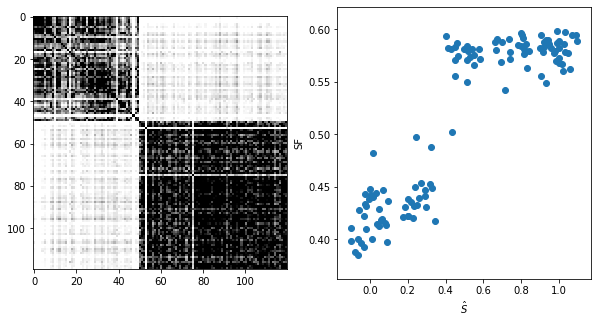

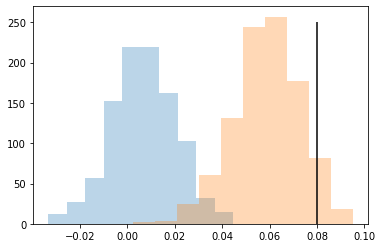

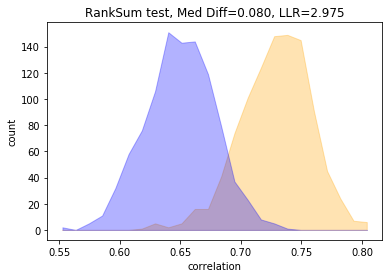

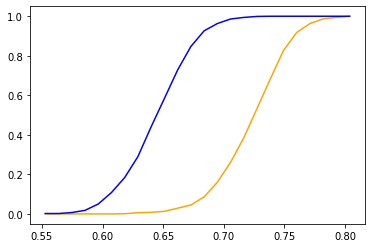

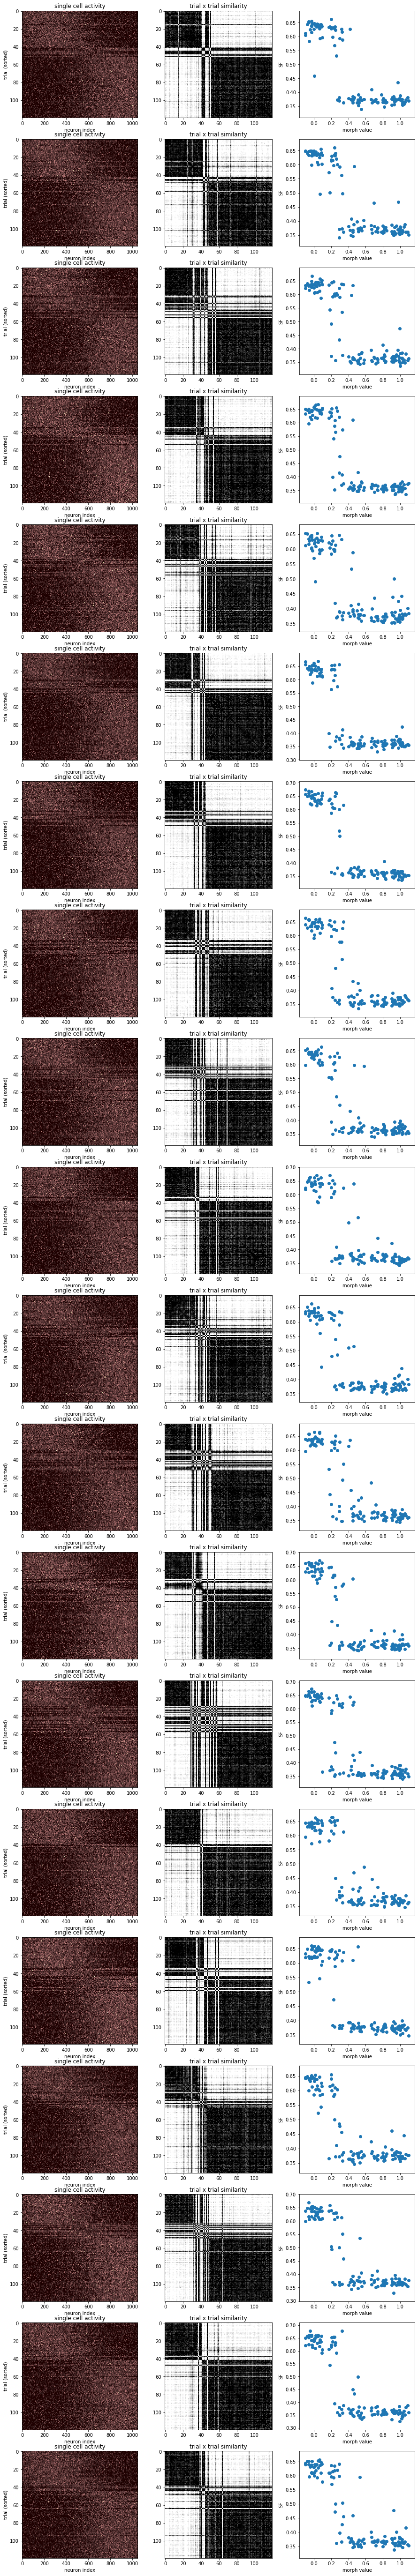

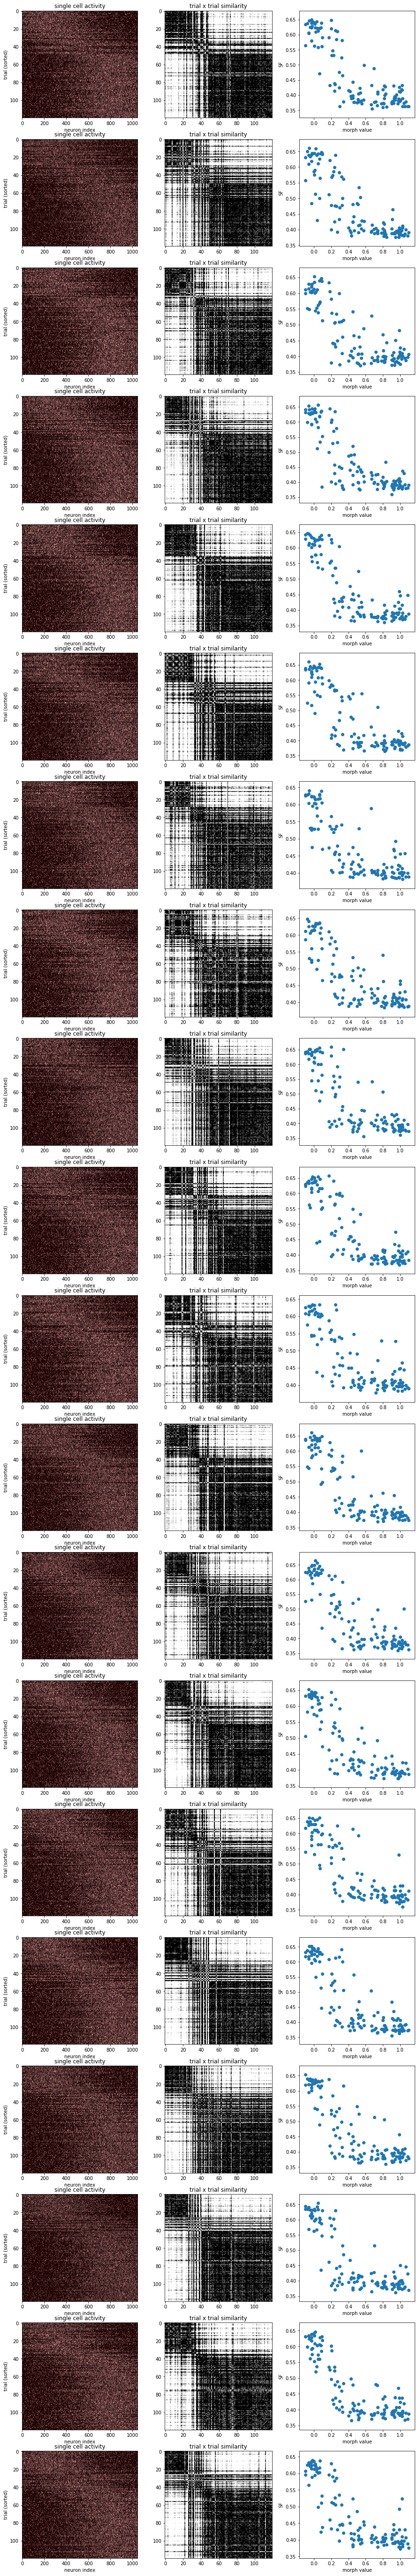

In [250]:
mouse = '4139265.5'
df_mouse = df[df["MouseName"]==mouse]
simulate_session_plot_results(df_mouse.iloc[-1])

In [ ]:
mouse = '4222174.1'
df_mouse = df[df["MouseName"]==mouse]
sess = df_mouse.iloc[-1]
sessdir = os.path.join("D:\\Morph_Results\\figures\\TheoreticalSimMats\\","%s_%s_%i" % (sess["MouseName"],sess["DateFolder"],sess["SessionNumber"]))
with open(os.path.join(sessdir,'simresults.pkl'),'rb') as file:
        results = pickle.load(file)

In [227]:
# for rare and freq keys

def likelihood_ratio_and_plot(sess):
    sessdir = os.path.join("D:\\Morph_Results\\figures\\TheoreticalSimMats\\","%s_%s_%i" % (sess["MouseName"],sess["DateFolder"],sess["SessionNumber"]))
    with open(os.path.join(sessdir,'simresults.pkl'),'rb') as file:
        results = pickle.load(file)
    scores, labels = np.concatenate([results['corr_rare'],results['corr_freq']]),np.zeros([2000,])
    labels[:1000]=1
    print(scores.shape,labels.shape)
#     print(sk.metrics.roc_auc_score(labels,scores))
    # ROC = sk.metrics.roc_auc_score(labels,scores)
    ROC = np.median(results['corr_rare'])-np.median(results['corr_freq'])
    print(ROC)
    null_dist = {}
    SIMDATA_SM = results['SIMDATA_SM']
    keys = ['rare','freq']

    for ind  in [0,1]:
        same_sms = SIMDATA_SM[keys[ind]]
        same_sms = sp.stats.zscore(same_sms.reshape(same_sms.shape[0],-1),axis=1)
        diff_sms = SIMDATA_SM[keys[ind-1]]
        diff_sms = sp.stats.zscore(diff_sms.reshape(diff_sms.shape[0],-1),axis=1)
        null_dist[keys[ind]]=[]
        for row in range(SIMDATA_SM[keys[ind]].shape[0]):
            mask = np.ones((same_sms.shape[0],))
            mask[row]=0
            mask = mask>0

            test,train = same_sms[row,:], same_sms[mask,:]
    #         print(test.shape,train.shape)
            corr_same, corr_diff = np.dot(train,test)/test.shape[0],np.dot(diff_sms,test)/test.shape[0]
            scores = np.concatenate((corr_same.ravel(),corr_diff.ravel()))
            labels = 0*scores
            if ind == 0:
                roc = np.median(corr_same)-np.median(corr_diff)
    #             labels[:corr_same.shape[0]]=1
            else:
    #             labels[corr_same.shape[0]:]=1
                roc = np.median(corr_diff)-np.median(corr_same)


    #         roc = sk.metrics.roc_auc_score(labels,scores)

            if row%100==0:
                print(row,roc)
            null_dist[keys[ind]].append(roc)
   
        null_dist[keys[ind]]=np.array(null_dist[keys[ind]])

    scores= np.concatenate([results['corr_rare'],results['corr_freq']])
    null_dist['perm']=np.zeros((1000,))
    for p in range(1000):
        labels = 0*scores
        labels[np.random.permutation(2000)[:1000]]=1
        null_dist['perm'][p]=sk.metrics.roc_auc_score(labels,scores)
        if p%100==0:
            print('perm', p,null_dist['perm'][p] )
            
    f,ax = plt.subplots()
    ax.hist(null_dist['freq'],alpha=.3)
    ax.hist(null_dist['rare'],alpha=.3)
    ax.vlines(ROC,0,250)
    f.savefig(os.path.join(sessdir,"null_dists.pdf"),format='pdf')
    f.savefig(os.path.join(sessdir,"null_dists.png"),format='png')
    
    
    llr = np.log10(np.maximum((null_dist['rare']<ROC).sum()/null_dist['rare'].size ,epsilon)) - np.log10(np.maximum((null_dist['freq']>ROC).sum()/null_dist['freq'].size ,epsilon))
    print('llr',llr)
    results['llr']=llr
    results['null_dist']=null_dist
    results['test_statistic']=ROC
    with open(os.path.join(sessdir,'simresults.pkl'),'wb') as file:
        pickle.dump(results,file)

(2000,) (2000,)
0.044494858668707726
0 0.04337806154667412
100 0.03800160134469355
200 0.03382095093338522
300 0.0655120928744023
400 0.05997977570987523
500 0.06367764541620347
600 0.05091751269592515
700 0.05798982736513314
800 0.057992299888868115
900 0.05560007010948875
0 0.034499018253119296
100 0.0021103928244642356
200 0.003097117053552978
300 -0.028835565869574142
400 0.023283980606822574
500 0.014820169420486473
600 0.028406530099038818
700 -0.011909328928302543
800 -0.004535332110771728
900 -0.008123756269984739
perm 0 0.506149
perm 100 0.488163
perm 200 0.49352799999999997
perm 300 0.48817200000000005
perm 400 0.49973900000000004
perm 500 0.487614
perm 600 0.48725199999999996
perm 700 0.506157
perm 800 0.5049549999999999
perm 900 0.503347
llr 2.5065050324048723
(2000,) (2000,)
0.046101951128822205
0 0.014525807661891599
100 0.03912190823993045
200 0.039393808505048034
300 0.07175420697483004
400 0.06837071380359638
500 0.05738836465532049
600 0.043358397787326086
700 0.05229

C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr 0.515873843711679
(2000,) (2000,)
-0.0027098484649492605
0 0.04848678162883424
100 0.05326098056122863
200 0.04296395470974601
300 0.05282134986253573
400 0.05227931838931377
500 0.07092908263157427
600 0.04596191814535189
700 0.07378596827752659
800 0.03380959533284844
900 0.03708896685713148
0 0.006905495835371034
100 -0.004084587659545003
200 -0.009544804712710797
300 -0.0073745839203821495
400 0.017967423480455547
500 0.006372218829704068
600 -0.019938993806291494
700 -0.009268836956794702
800 0.007117439714006579
900 0.019419793095199034
perm 0 0.49374399999999996
perm 100 0.481321
perm 200 0.48416999999999993
perm 300 0.485453
perm 400 0.511349
perm 500 0.49834
perm 600 0.5252829999999999
perm 700 0.5131220000000001
perm 800 0.49248899999999995
perm 900 0.479409


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.792391689498254
(2000,) (2000,)
0.007992989954141105
0 0.0843700014907729
100 0.07854767694976028
200 0.062105206748609754
300 0.08636638632137594
400 0.09034972477960523
500 0.08432699273941735
600 0.11103002951674601
700 0.07800244376134535
800 0.08610068535027082
900 0.05777690208554698
0 0.016460522519881837
100 0.03452373860125457
200 -0.0147971712922087
300 0.06474062131000935
400 0.019982411859645444
500 0.024777382978182105
600 0.015860314805974607
700 0.03738347490517224
800 0.023964439723136888
900 0.03348910664060467
perm 0 0.49777099999999996
perm 100 0.492607
perm 200 0.475135
perm 300 0.49013700000000004
perm 400 0.477746
perm 500 0.49099499999999996
perm 600 0.497449
perm 700 0.481071
perm 800 0.518455
perm 900 0.5005740000000001


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.8444771757456815
(2000,) (2000,)
0.02036157587926235
0 0.058645165142895306
100 0.07129548002208141
200 0.07092704793669768
300 0.056364843388576724
400 0.055284372306879104
500 0.01826300776214218
600 0.023899407375298165
700 0.03432902120202064
800 0.06984609329774116
900 0.04522246454803325
0 -0.013356842907191413
100 -2.097085209684657e-05
200 0.025148651207247186
300 0.009873021288583916
400 -0.0018826286604349818
500 0.0011514548639648403
600 -0.002573706716624269
700 0.004840677466126486
800 0.01962108191433809
900 -0.004462743524454638
perm 0 0.505832
perm 100 0.5042559999999999
perm 200 0.505162
perm 300 0.499007
perm 400 0.501308
perm 500 0.504607
perm 600 0.503904
perm 700 0.4916400000000001
perm 800 0.476009
perm 900 0.516248


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -1.406540180433955
(2000,) (2000,)
-0.025210789164268665
0 0.037858133052317666
100 0.04890324671889823
200 0.048799509186226886
300 0.06680569857190422
400 0.06857093970126571
500 0.05778111665612351
600 0.04695920769163886
700 0.07038389621299512
800 0.055386426639532416
900 0.07361626385242859
0 -0.007796023122234597
100 0.0028002416130117336
200 0.02195989476808813
300 0.008367305713951945
400 0.010736838959299999
500 0.0019962421432608846
600 0.006004146769042151
700 -0.04110997107662384
800 -0.006916291573596189
900 -0.024896621415073872
perm 0 0.5073650000000001
perm 100 0.507875
perm 200 0.502794
perm 300 0.5256730000000001
perm 400 0.502746
perm 500 0.46487900000000004
perm 600 0.49756999999999996
perm 700 0.5143869999999999
perm 800 0.5042070000000001
perm 900 0.501072


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.9845273133437926
(2000,) (2000,)
-0.01743412154215007
0 0.05861770988900139
100 0.03919896246978549
200 0.04994785533923962
300 0.06733256598216308
400 0.04300861172499726
500 0.051606247456798426
600 0.028378891431699804
700 0.07457534071918459
800 0.03427005722335308
900 0.058037807678857356
0 -0.012586968245919317
100 -0.01153226942606378
200 -0.00947551333062513
300 -0.009679920145384102
400 0.005099872892043722
500 -0.010601330260800679
600 0.006655313940737484
700 -0.018360932577024425
800 -0.0280851698027359
900 0.01123370353740527
perm 0 0.5111559999999999
perm 100 0.494643
perm 200 0.517678
perm 300 0.5010399999999999
perm 400 0.520912
perm 500 0.49264
perm 600 0.499945
perm 700 0.5031019999999999
perm 800 0.503733
perm 900 0.506578


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.9633155113861114
(2000,) (2000,)
-0.019370906926533316
0 0.08719972197378023
100 0.06132464454379516
200 0.08086547450599912
300 0.08015969684990298
400 0.05265232648374907
500 0.049951547203016644
600 0.03978462273103889
700 0.041323208710362325
800 0.04872915722121185
900 0.052142022212917416
0 0.01272578950430514
100 0.028190054324992886
200 -0.010510246202182882
300 0.03742203787691101
400 -0.013256359449981603
500 0.008652647385946288
600 0.023223183506225764
700 0.009741650294353588
800 -0.010607550810675992
900 -0.007016501952113785
perm 0 0.49182200000000004
perm 100 0.502745
perm 200 0.498909
perm 300 0.4771770000000001
perm 400 0.5060089999999999
perm 500 0.515108
perm 600 0.496458
perm 700 0.49523
perm 800 0.5140990000000001
perm 900 0.521572


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.9845273133437926
(2000,) (2000,)
-0.02279780899135586
0 0.061309226132491235
100 0.04932796105860593
200 0.05793767652445414
300 0.08345087090315007
400 0.08259092756117048
500 0.09583693613818967
600 0.05575522468425276
700 0.026395377628408156
800 0.05290277206145633
900 0.05669713676382693
0 -0.006547373944864376
100 0.029663580993974925
200 -0.027071625456364656
300 -0.02905866442805516
400 0.012053632886754317
500 0.0012770409257774062
600 -0.01082871024927523
700 0.03256356738873423
800 -0.023600747314395543
900 0.04243112151541628
perm 0 0.494876
perm 100 0.48806200000000005
perm 200 0.477472
perm 300 0.504313
perm 400 0.49153500000000006
perm 500 0.48787400000000003
perm 600 0.5174869999999999
perm 700 0.521899
perm 800 0.485572
perm 900 0.518493


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.959994838328416
(2000,) (2000,)
-0.012645921437571372
0 0.04604189019510585
100 0.039156289731913096
200 0.05294873178917392
300 0.02930737905872982
400 0.04669482177193773
500 0.03759314533057856
600 0.05229002436248742
700 0.06390663320214529
800 0.05963730340129647
900 0.043766785039927925
0 0.012306393271530047
100 0.02184609195578202
200 0.0207555836425527
300 -0.0028998844311703964
400 0.011402649202250759
500 0.03840788366282888
600 0.02517214180200833
700 0.03540182233350675
800 0.004970806785657755
900 0.015573476464217917
perm 0 0.48700299999999996
perm 100 0.5043789999999999
perm 200 0.495888
perm 300 0.463712
perm 400 0.511215
perm 500 0.48959699999999995
perm 600 0.505438
perm 700 0.49364299999999994
perm 800 0.5077659999999999
perm 900 0.48649700000000007


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.979548374704095
(2000,) (2000,)
0.0021746072536099614
0 0.04088351177109051
100 0.0438735658974333
200 0.0568562262710367
300 0.04560912570354769
400 0.062424049537750825
500 0.05085421229399223
600 0.045586002874229314
700 0.01830022676734988
800 0.05789054533057825
900 0.03642786739311421
0 -0.008730572323771502
100 -0.0018801341845281483
200 -0.008562297158668408
300 -0.020510316618307933
400 -0.004144722738492312
500 -0.0019940056092240255
600 -0.012229045949773476
700 -0.006982450767740622
800 0.01068597836605889
900 -0.0043467830547768704
perm 0 0.49358899999999994
perm 100 0.521424
perm 200 0.49061200000000005
perm 300 0.512929
perm 400 0.498388
perm 500 0.502895
perm 600 0.503567
perm 700 0.490232
perm 800 0.507606
perm 900 0.51747


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.094587577089025
(2000,) (2000,)
-0.004747542836123553
0 0.05400576539216406
100 0.07499503513558381
200 0.041052874557051755
300 0.05846478303097258
400 0.05291904135851211
500 0.03060757666949543
600 0.052203600985091914
700 0.04073745528158679
800 0.0403596804795352
900 0.06862598987403268
0 -0.024204501742391527
100 0.019411385954490212
200 0.031500795575987284
300 0.006032899778226519
400 -0.017143912876131595
500 -0.01129592920881306
600 -0.013610422636828212
700 0.012891146492317374
800 -0.004981316882856079
900 -0.015304957014659948
perm 0 0.481375
perm 100 0.511556
perm 200 0.494864
perm 300 0.521875
perm 400 0.512027
perm 500 0.48733400000000004
perm 600 0.491617
perm 700 0.505124
perm 800 0.48966
perm 900 0.49497099999999994


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.6283889300503116
(2000,) (2000,)
0.02400251609264825
0 0.0375817088964423
100 0.01418053022148913
200 0.07526091696878334
300 0.027574635071578757
400 0.015060490896180001
500 0.05743708151192606
600 0.04773717148197232
700 0.045587514618626535
800 0.040027639400419424
900 0.05358240388696334
0 0.009180204730537045
100 -0.016535419226489934
200 0.0008986377222716113
300 -0.01927175143444637
400 -0.00214610345193722
500 -0.03554807615050681
600 -0.018480428897501566
700 -0.013047298676884811
800 -0.005046913646677864
900 -0.0006263357804565661
perm 0 0.514571
perm 100 0.505355
perm 200 0.48173399999999994
perm 300 0.5275650000000001
perm 400 0.50471
perm 500 0.510591
perm 600 0.501589
perm 700 0.497158
perm 800 0.498173
perm 900 0.497339


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr 0.6869610968630034
(2000,) (2000,)
-0.026088201542821876
0 0.01654955833327365
100 0.03570674336324231
200 0.048538288138408325
300 0.040819450465804485
400 0.03743382345869106
500 0.04267711196058255
600 0.07118712621044887
700 0.05011583111048812
800 0.06447792538686714
900 0.04334222820240097
0 0.0006359205971551152
100 -0.010506974414614456
200 -0.035226216346082806
300 0.009391863857644345
400 0.014650473541221398
500 0.0266090705765627
600 0.005842000339959963
700 -0.008579263001840975
800 -0.016989774021979764
900 -0.007390648041007863
perm 0 0.49829600000000007
perm 100 0.483263
perm 200 0.488955
perm 300 0.505452
perm 400 0.49857
perm 500 0.503851
perm 600 0.503694
perm 700 0.480349
perm 800 0.47263299999999997
perm 900 0.489387


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.9618954736678504
(2000,) (2000,)
-0.002363967406970313
0 0.061564853238298856
100 0.05079274115276322
200 0.053037671279606347
300 0.03174879295298494
400 0.058609320822264555
500 0.04637150016221814
600 0.039761071803166126
700 0.03150209843890295
800 0.07372091086387034
900 0.020775246089008492
0 -0.019666144981524192
100 -0.0013684783099122688
200 -0.015562454043828722
300 -0.007317549670504686
400 -0.012277386882827646
500 -0.015240918221713806
600 0.01410934122917995
700 -0.009644780967099087
800 -0.0025041581105780253
900 -0.03291351606203774
perm 0 0.487655
perm 100 0.504883
perm 200 0.480651
perm 300 0.5079009999999999
perm 400 0.505175
perm 500 0.510594
perm 600 0.49518000000000006
perm 700 0.5030399999999999
perm 800 0.504102
perm 900 0.50946


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.5224442335063197
(2000,) (2000,)
-0.028939307118902025
0 0.019438728951875817
100 0.007354789475717438
200 0.04335516004508533
300 0.020529709733084323
400 0.024680171708055143
500 0.03638609580226004
600 0.029243942445825843
700 0.03023753265668727
800 0.04811936075849976
900 0.028322720941887147
0 0.0017497730530871003
100 -0.018703989730934345
200 0.0015792161503186408
300 0.010202762482724337
400 -0.00042720730973022647
500 -0.011792846580219729
600 0.0012907441060001634
700 -0.0165225165590438
800 0.010098022242659654
900 -0.003974992950221856
perm 0 0.474313
perm 100 0.49983
perm 200 0.499301
perm 300 0.48546600000000006
perm 400 0.510435
perm 500 0.513382
perm 600 0.512246
perm 700 0.518187
perm 800 0.5028110000000001
perm 900 0.48041599999999995


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.9965116721541785
(2000,) (2000,)
-0.03392399001204627
0 0.03915834832889409
100 0.06910821084788965
200 0.07358452391559356
300 0.07398887049949887
400 0.042068751662113324
500 0.09619606934190128
600 0.04334583011779325
700 0.05288824001949288
800 0.06975528417511889
900 0.06857691314883252
0 0.0097966385521141
100 -0.008409651273436514
200 -0.004475305030007926
300 -0.024234648305067386
400 0.0015154246980414454
500 0.014407231350666017
600 0.037861528739320804
700 -0.007889588549909399
800 -0.0019938235062541
900 -2.724416897559312e-05
perm 0 0.4858800000000001
perm 100 0.500287
perm 200 0.518006
perm 300 0.52807
perm 400 0.500468
perm 500 0.502527
perm 600 0.503015
perm 700 0.506372
perm 800 0.505484
perm 900 0.514695


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.9921114877869495
(2000,) (2000,)
-0.04330252692490211
0 0.03632740149384428
100 0.0475099744052494
200 0.05215264704318223
300 0.043520634353606424
400 0.030654767825590512
500 0.05144702711319493
600 0.033721221174688565
700 0.04140714935707246
800 0.04303273309644229
900 0.02687200737760065
0 -0.03175860505854822
100 0.0009363611848649533
200 -0.013068415287705748
300 -0.007958857957682475
400 -0.00021640579197490517
500 0.004754210946942727
600 0.0024841916082544158
700 0.02960233771173404
800 -0.0146064451460175
900 0.007472294624086384
perm 0 0.513176
perm 100 0.49157400000000007
perm 200 0.49920400000000004
perm 300 0.526565
perm 400 0.508642
perm 500 0.4851
perm 600 0.512902
perm 700 0.495607
perm 800 0.510382
perm 900 0.5180449999999999


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.999130541287371
(2000,) (2000,)
-0.029668569460400196
0 0.03648516180257866
100 0.0715598157259777
200 0.03504170178738841
300 0.07103095232757528
400 0.046017997934369004
500 0.07214376816288581
600 0.04251718678620919
700 0.04799013861619139
800 0.049615173631925025
900 0.03812987677991575
0 -0.007883360850527321
100 -0.004224619181053102
200 -0.008862029135695448
300 0.003918701311381723
400 0.00812328224095149
500 -0.0034635552727148022
600 -0.000807463309467793
700 -0.015558633268132005
800 0.00765627519946388
900 -0.00417221831056136
perm 0 0.48451900000000003
perm 100 0.507028
perm 200 0.508195
perm 300 0.47519500000000003
perm 400 0.48159700000000005
perm 500 0.5067619999999999
perm 600 0.47626900000000005
perm 700 0.528043
perm 800 0.48826899999999995
perm 900 0.49999299999999997


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -2.9921114877869495
(2000,) (2000,)
-0.0407302842493954
0 0.03919022908276404
100 0.030082032351214316
200 0.060271312971099444
300 0.06475319707985683
400 0.04857921649388586
500 0.029703471360683964
600 0.048816054076567195
700 0.039687354445716694
800 0.042975091114531794
900 0.07510611566324321
0 0.006468075890679326
100 0.016444259595957966
200 -0.0033086045965163846
300 0.0034342623842423814
400 0.005236587288551253
500 0.024889242082757224
600 0.009788711055036092
700 0.008657837542543345
800 -0.004011771675906939
900 0.005447924313196517
perm 0 0.5147849999999999
perm 100 0.521943
perm 200 0.489195
perm 300 0.49704599999999993
perm 400 0.49162300000000003
perm 500 0.513811
perm 600 0.514076
perm 700 0.49432699999999996
perm 800 0.48392199999999996
perm 900 0.4924


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -3.0
(2000,) (2000,)
-0.05288326695736889
0 0.040738944493404206
100 0.07271242548284385
200 0.052152240962149765
300 0.049704578437614444
400 0.04387931253537469
500 0.07390140627523878
600 0.06554733088540887
700 0.05620555713762021
800 0.0682126193103374
900 0.05101677787563397
0 -0.009167205476748208
100 -0.015480649702449334
200 -0.00497723818725071
300 -0.003240313725133892
400 -0.020397625786006235
500 0.0037166780434242375
600 -0.016833037367740444
700 0.012126412222755789
800 -0.0011817675151294393
900 -0.006069236949026724
perm 0 0.498925
perm 100 0.48829700000000004
perm 200 0.510336
perm 300 0.512238
perm 400 0.5025850000000001
perm 500 0.502596
perm 600 0.485849
perm 700 0.509076
perm 800 0.479751
perm 900 0.503214


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -3.0
(2000,) (2000,)
-0.05919882236205232
0 0.027723518955828697
100 0.029327700410208157
200 0.005143271202997957
300 0.013649497288939827
400 0.031190321000315158
500 0.01610396060443753
600 0.023426444297019233
700 0.03419670597417357
800 0.014369134702380992
900 0.023624774028115803
0 -0.013221278388132918
100 0.0042508430506583705
200 0.007745925953415167
300 -0.017567571280056704
400 -0.022505643951058918
500 -0.018723910368622865
600 -0.0199659421200562
700 -0.00469846395723994
800 -0.019324424563170184
900 -0.023759936314058705
perm 0 0.48182
perm 100 0.476763
perm 200 0.473592
perm 300 0.508802
perm 400 0.48994400000000005
perm 500 0.47643900000000006
perm 600 0.494841
perm 700 0.488638
perm 800 0.497487
perm 900 0.5108199999999999


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -3.0
(2000,) (2000,)
-0.04833614545045528
0 0.03560143149516515
100 0.06478119547034256
200 0.04184336645821829
300 0.05661039205597573
400 0.020417289132641847
500 0.05473517524615279
600 0.04793303147480599
700 0.05977282104940229
800 0.06577061301226284
900 0.049084055182822994
0 -0.006042306131464836
100 0.010666134754968248
200 0.007789121803355559
300 -0.004865478466573703
400 -0.0028796277356309963
500 0.0006849316619537138
600 -0.011874479115937087
700 -0.010052584094710326
800 0.016090564276284858
900 -0.0032431972902494666
perm 0 0.479624
perm 100 0.504329
perm 200 0.505643
perm 300 0.48807
perm 400 0.5098550000000001
perm 500 0.5058050000000001
perm 600 0.520875
perm 700 0.507521
perm 800 0.490806
perm 900 0.49685399999999996


C:\Users\markp\anaconda3\lib\site-packages\ipykernel_launcher.py:59: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


llr -3.0


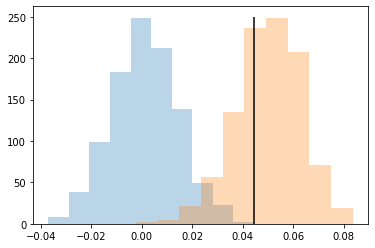

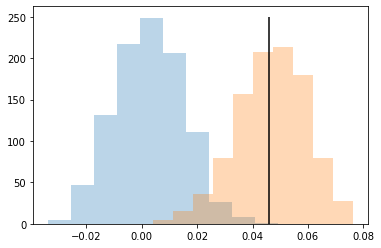

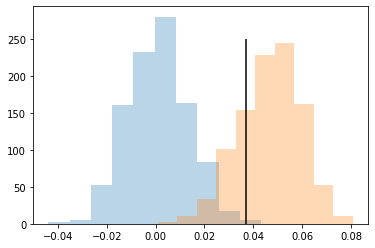

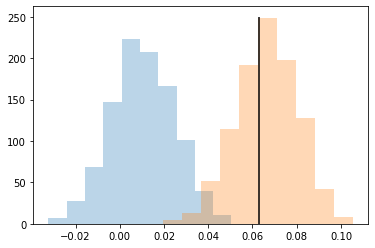

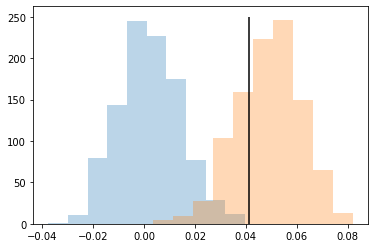

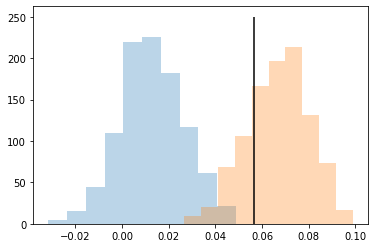

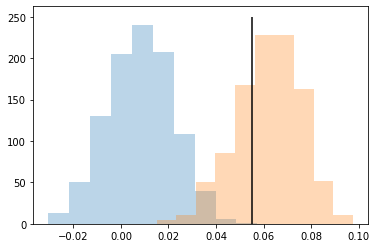

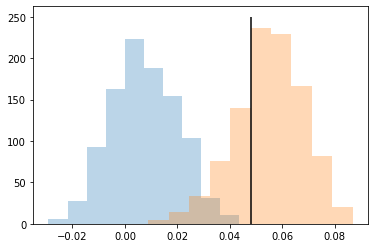

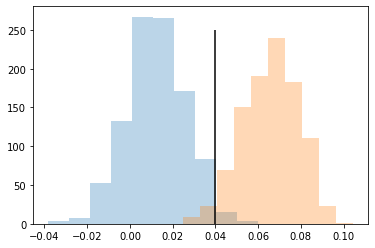

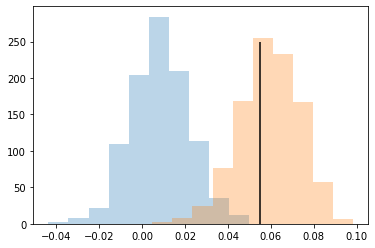

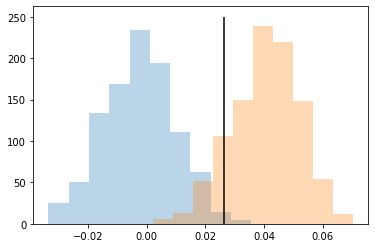

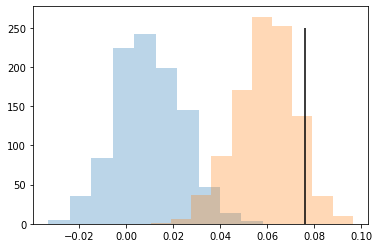

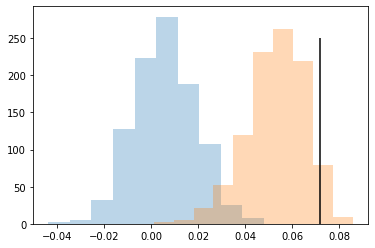

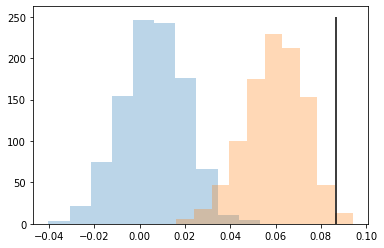

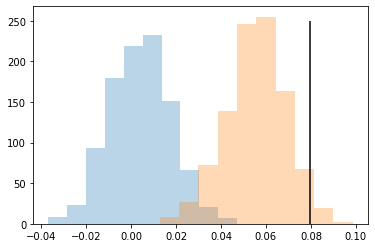

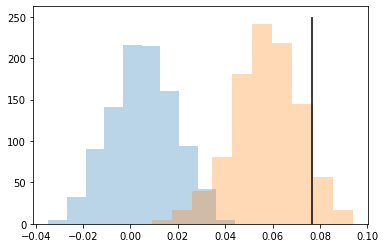

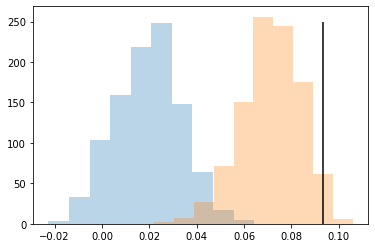

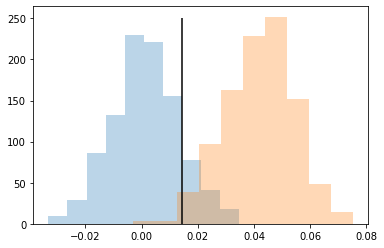

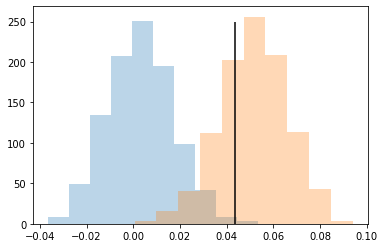

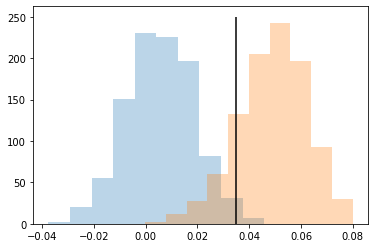

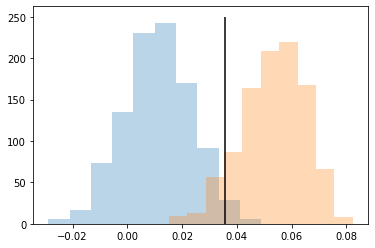

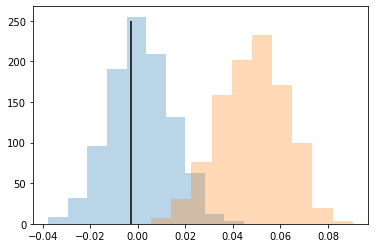

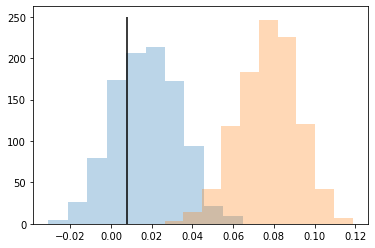

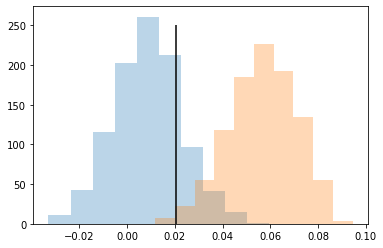

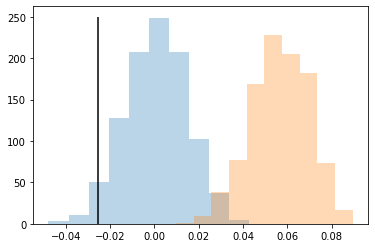

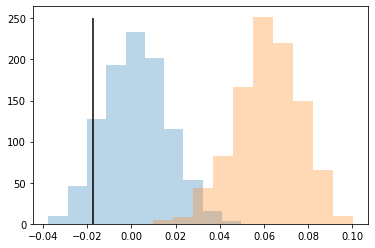

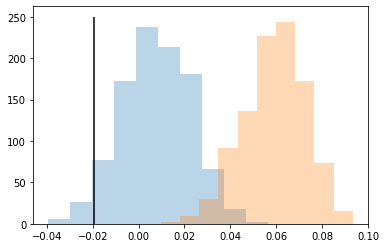

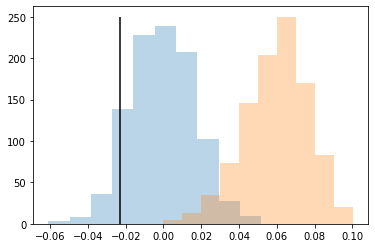

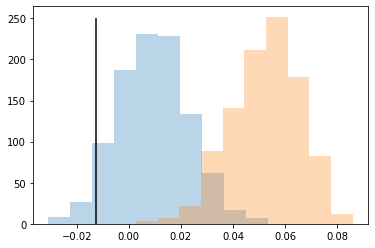

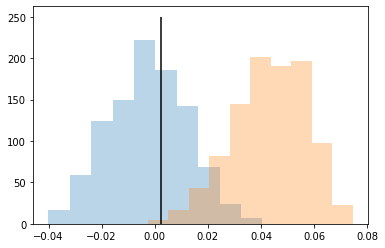

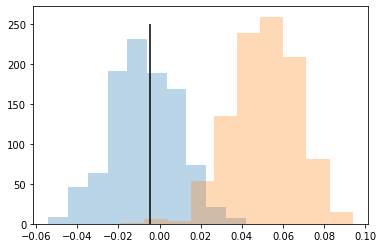

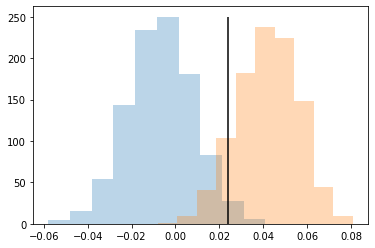

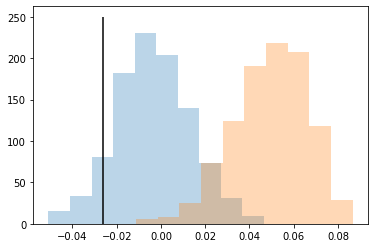

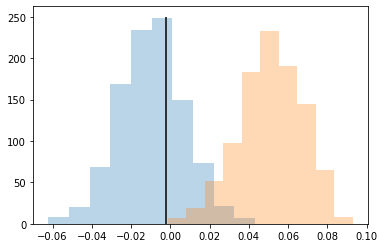

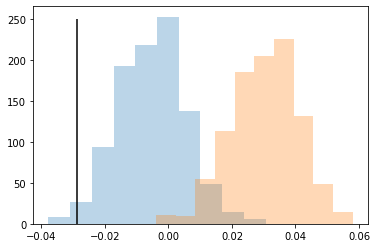

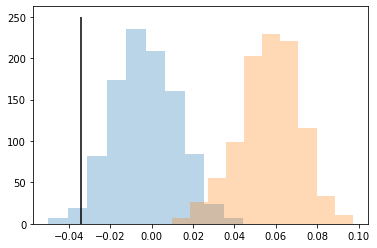

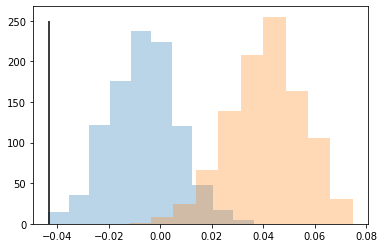

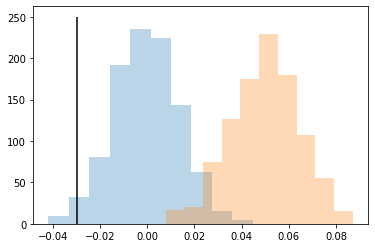

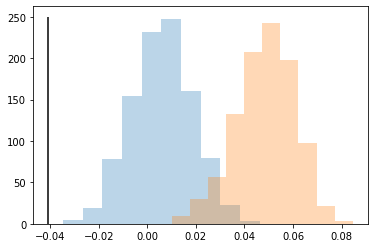

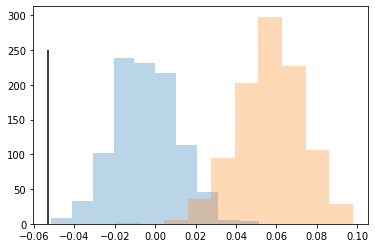

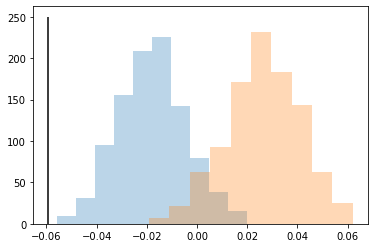

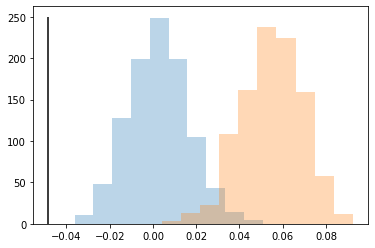

In [228]:
for (mouse, first_ind)  in zip(['4139265.3','4139265.4','4139265.5','4222168.1','4343703.1','4222153.1','4222153.2',
        '4222153.3','4222174.1','4222154.1','4343702.1'],[5,5,5,3,5,4,4,4,4,4,4]):
    df_mouse = df[df["MouseName"]==mouse]
    
    for sess_ind in range(first_ind,df_mouse.shape[0]):
        sess = df_mouse.iloc[sess_ind]
#         simulate_session_plot_results(sess)
        likelihood_ratio_and_plot(sess)